# Multiple support excitation za nosač jednoga raspona

<h1 id="tocheading">Sadržaj</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Skice

### Skica diskretiziranog nosača na četiri konačna elementa

Ovdje za primjer je dana prosta greda iako je moguće koristiti proračun s drugačijim rubnim uvjetima. Na skici je primjer bez dodatnih masa od utega.

<img src="model 7 masa.png" width="600" height="225" />

## Korištena literatura

~~~ ubaciti link

In [2]:
# ubaciti parametre iz predloska radi kontrole proracuna

## Paketi korišteni u proračunu

In [3]:
%matplotlib inline

In [4]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt

## Ulazni podaci

In [5]:
n_primjer = 4 # broj konačnih elemenata 
l = 2.0 # [m]
h, b = 0.013, 0.040 # [m]
I = b * h**3 / 12 # [m^4]
E = 12.5 * 10**9 # [N/m^2]
m_uk = 0.650 * 7/8 # [kg] ~~~ 7/8 jer je greda razrezana s 2.40 m na 2.10 m
rho = m_uk / (l*b*h) #[kg/m^3]
m_uteg = 0.1 # [kg]
ksi = 0.05 # vidjeti u eksperimentu
delay_t_primjer = 1.0 #[sec] kašnjenje potresnog signala
t = 5 #[sec] proračun se vrši samo za prvih 5 sekundi
r_u_l_primjer = "u" # rubni uvjet lijevo je upeti ležaj
r_u_d_primjer = "z" # rubni uvjet desno je zglobni ležaj

## Napomene:

- ~~ukoliko se kasnije zakomplicira proracun moguce je promijeniti matrice iz dense u sparse (sp.diag) na str. 240 knjige approach for industry~~

- veći utjecaj ima tuple unpacking.. 

- ~~možda osim funkcija ubaciti i interact za varijable s indeksom "_primjer" (što zasada ne radi online)~~

- Ubaciti prva tri tona na graf!

- ~~u funkciji def M(n) se masa ukupno m_uk dijeli na n+1 dijelova potrebna provjera (slika ne odgovara), masa koja ulazi u proračun će biti m_uk / (n-1) , a ne m_uk / n~~

- dodatne mase m_uteg su ubačene u matricu masa i sada programski kod dozvoljava n,2n,3n,... broj konačnih elemenata, a inače stvara Error s porukom upozorenja. Sada konvergencija prirodnih frekvencija više neće biti pogodna za ispis, ali je zadržana stara inačica koda pa će se moći od tamo uzeti (tamo je lumped mass model).

- potrebno izračunati ksi iz optičkih mjerenja

- ubaciti link za literaturu (pitati prof. Bićanića)

- ~~u obradu potresnih zapisa je ubačena interpolacija koja dozvoljava precizniji proračun u slučaju korištenja manjeg vremenskog koraka~~

- ~~potresna ekscitacija se ostvaruje i na kutevima zaokreta, iako funkcija Gama sugerira da neće postojati ekscitacija kod kuteva zaokreta. "Problem" nastaje radi kašnjenja signala - vjerovatno procedura daje dobre rezultate.~~

- masa cjelokupne grede l = 2,10 m je raspoređena na dio između oslonaca l = 2,00 m

- ~~vidjeti šta je s plavom linijom u troubleshootu~~

- delta_t se konačno definira kasnije u proračunu ovisno o periodu najvećeg značajnog tona odnosno četvrtog tona

In [6]:
# rezultati će svugdje biti zaokruženi na 2 decimale
np.set_printoptions(precision=2)

## Matrica masa

Ovaj korak u literaturi je nazvan Step 1. U poglavlju Rubni uvjeti se definiraju matrice masa potrebne za daljnji proračun. Cjelokupna matrica masa ovako izgleda:

$$\begin{bmatrix}
    M_{ss} & M_{sg}\\
    M_{gs} & M_{gg}\\
\end{bmatrix}$$

gdje su:

- $M$ - cjelokupna matrica krutosti

- $M_{ss}$ - matrica masa konstrukcije (eng. "super structure/ non-support degree of freedom")

- $M_{sg}, M_{gs}, M_{gg}$ - matrice masa s masama uz oslonce (eng. "support degree of freedom")

Procedura kreiranja lumped mass matrice masa je deaktivirana #. Sustav nije statički spregnut - radi točnosti i radi potreba proračuna.

In [7]:
#def M_osn(n):
#    """Assembly osnovne matrice masa ovisno o broju konačnih elemenata n.
#    Kutevima zaokreta se pridružuju zanemarive mase što je nužno radi
#    kasnijeg inverza ove funkcije."""
#    return np.diag((m_uk/(n+1),m_uk/(n+1)/100)*(n+1))

### Matrica masa jednog konačnog elementa

Koristiti će se konzistentna matrica masa. U kodu je pod imenom M_1, a dolje je dan simbolični prikaz iste.

$$  M_e = \frac {\rho A l} {420} \begin{bmatrix}
    156 & 22 l & 54 & -13 l\\
    22 l & 4 l^2 & 13 l & -3 l^2\\
    54 & 13 l & 156 & -22 l\\
    -13 l & -3 l^2 & -22 l & 4 l^2\\
\end{bmatrix} $$


In [8]:
def M_1(n):
    return rho*(b*h)*(l/n)/420 * np.array([[156, 22*(l/n), 54, -13*(l/n)],
                                           [22*(l/n), 4*(l/n)**2, 13*(l/n), -3*(l/n)**2],
                                           [54, 13*(l/n), 156, -22*(l/n)],
                                           [-13*(l/n), -3*(l/n)**2, -22*(l/n), 4*(l/n)**2]])
M_1(n_primjer)

array([[ 0.05,  0.  ,  0.02, -0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ],
       [ 0.02,  0.  ,  0.05, -0.  ],
       [-0.  , -0.  , -0.  ,  0.  ]])

### Slaganje mreže konačnih elemenata - assembly matrice masa

Cjelokupna matrica masa je ekvivalentna osnovnoj osim u razmeštaju redaka i stupaca.

U eksperimentu su dodani utezi na četvrtinama raspona, tako da je dodano tri utega. Masa od dodanih utega se pridodaje na odgovarajuća mjesta. Provjera dobre raspodjele utega će na neki način biti ispis konvergencije tonova s povećanjem broja konačnih elemenata - u poglavlju pod nazivom Ispis frekvencije prvog tona za različite rubne uvjete.

In [9]:
def M_osn(n):
    """Assembly osnovne matrice masa ovisno o broju konačnih elemenata n."""
    pomocna_matrica = np.zeros((2*(n+1), 2*(n+1))) # iniciranje nul - matrice
    for i in range(n):
        pomocna_matrica[2*i:2*i+4, 2*i:2*i+4] += M_1(n) 
    if n%n_primjer == 0:
        for j in [1,2,3]:
            pomocna_matrica[j*n//2,j*n//2] += m_uteg
    #elif n%n_primjer != 0:
    #    print("NAPOMENA: Ovakvom diskretizacijom je nemoguće rasporediti dodane utege")
    return pomocna_matrica

print(M_osn(n_primjer*1-1)) # nema dodanih masa

[[ 0.07  0.01  0.02 -0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.   -0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.14  0.    0.02 -0.    0.    0.  ]
 [-0.   -0.    0.    0.    0.   -0.    0.    0.  ]
 [ 0.    0.    0.02  0.    0.14  0.    0.02 -0.  ]
 [ 0.    0.   -0.   -0.    0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.02  0.    0.07 -0.01]
 [ 0.    0.    0.    0.   -0.   -0.   -0.01  0.  ]]


## Matrica krutosti

Ovaj korak u literaturi je nazvan Step 2. U poglavlju Rubni uvjeti se definiraju matrice krutosti potrebne za daljnji proračun. Cjelokupna matrica krutosti ovako izgleda:

$$\begin{bmatrix}
    K_{ss} & K_{sg}\\
    K_{gs} & K_{gg}\\
\end{bmatrix}$$

gdje su:

- $K$ - cjelokupna matrica krutosti

- $K_{ss}$ - statička matrica krutosti konstrukcije (eng. "super structure/ non-support degree of freedom")

- $K_{sg}, K_{gs}, K_{gg}$ - matrice krutosti s krutostima oslonaca (eng. "support degree of freedom")

### Matrica krutosti jednog konačnog elemenata

Koristi se inženjerska matrica krutosti. U kodu je pod imenom K_1, a donja tablica daje prikaz iste u simboličnom obliku.

$$\begin{bmatrix}
    \frac{12 E I}{l^3} & \frac{6 E I}{l^2} & \frac{-12 E I}{l^3} & \frac{6 E I}{l^2} \\
    \frac{6 E I}{l^2} & \frac{4 E I}{l} & \frac{-6 E I}{l^2} & \frac{2 E I}{l} \\
    \frac{-12 E I}{l^3} & \frac{-6 E I}{l^2} & \frac{12 E I}{l^3} & \frac{-6 E I}{l^2} \\
    \frac{6 E I}{l^2} & \frac{2 E I}{l} & \frac{-6 E I}{l^2} & \frac{4 E I}{l} \\
\end{bmatrix}$$

In [10]:
def K_1(n):
    return np.array([[12*E*I/(l/n)**3, 6*E*I/(l/n)**2, -12*E*I/(l/n)**3, 6*E*I/(l/n)**2],
                    [6*E*I/(l/n)**2, 4*E*I/(l/n), -6*E*I/(l/n)**2, 2*E*I/(l/n)],
                    [-12*E*I/(l/n)**3, -6*E*I/(l/n)**2, 12*E*I/(l/n)**3, -6*E*I/(l/n)**2],
                    [6*E*I/(l/n)**2, 2*E*I/(l/n), -6*E*I/(l/n)**2, 4*E*I/(l/n)]])
K_1(n_primjer)

array([[ 8788.  ,  2197.  , -8788.  ,  2197.  ],
       [ 2197.  ,   732.33, -2197.  ,   366.17],
       [-8788.  , -2197.  ,  8788.  , -2197.  ],
       [ 2197.  ,   366.17, -2197.  ,   732.33]])

### Slaganje mreže konačnih elemenata - assembly matrice krutosti

Cjelokupna matrica krutosti je ekvivalentna osnovnoj osim u razmeštaju redaka i stupaca.

In [11]:
def K_osn(n):
    """Assembly osnovne matrice krutosti ovisno o broju konačnih elemenata n."""
    pomocna_matrica = np.zeros((2*(n+1), 2*(n+1))) # iniciranje nul - matrice
    for i in range(n):
        pomocna_matrica[2*i:2*i+4, 2*i:2*i+4] += K_1(n) 
    return pomocna_matrica
print(K_osn(n_primjer))

[[  8788.     2197.    -8788.     2197.        0.        0.        0.
       0.        0.        0.  ]
 [  2197.      732.33  -2197.      366.17      0.        0.        0.
       0.        0.        0.  ]
 [ -8788.    -2197.    17576.        0.    -8788.     2197.        0.
       0.        0.        0.  ]
 [  2197.      366.17      0.     1464.67  -2197.      366.17      0.
       0.        0.        0.  ]
 [     0.        0.    -8788.    -2197.    17576.        0.    -8788.
    2197.        0.        0.  ]
 [     0.        0.     2197.      366.17      0.     1464.67  -2197.
     366.17      0.        0.  ]
 [     0.        0.        0.        0.    -8788.    -2197.    17576.
       0.    -8788.     2197.  ]
 [     0.        0.        0.        0.     2197.      366.17      0.
    1464.67  -2197.      366.17]
 [     0.        0.        0.        0.        0.        0.    -8788.
   -2197.     8788.    -2197.  ]
 [     0.        0.        0.        0.        0.        0.     2197.
   

## Rubni uvjeti

Ovaj korak nije naveden u koracima literature, a potreban je za generalizaciju proračuna. Ideja je da se za svaku kombinaciju rubnih uvjeta izvrše potrebna premještanja redaka i stupaca ili brisanje istih. Time se dobiju matrice $K_{ss}$, $K_{sg}$ i $M_{ss}$ koje su potrebne za proracun. Rubni uvjeti se definiraju kao "u" za upeti oslonac i kao "z" za zglobni oslonac.
- r_u_l - rubni uvjet na lijevom osloncu 
- r_u_d - rubni uvjet na desnom osloncu
- K_ss - statička matrica krutosti konstrukcije (super structure/ non-support degree of freedom) $K_{ss}$
- K_sg - matrica krutosti s krutosti oslonaca (support degree of freedom) $K_{sg}$
- M_ss - matrica masa konstrukcije (eng. "super structure/ non-support degree of freedom") $M_{ss}$

In [12]:
def premjestanje(i):
    """
    Pomocna funkcija koja daje raspored po kojoj se premjestaju 
    retci i stupci osnovne matrice krutosti
    """
    return np.argsort(np.argsort(i)) # najbrzi nacin za mali broj konacnih elemenata

def rubni_uvjeti(n, r_u_l, r_u_d):
    """
    Uvrštavanje rubnih uvjeta u matricu krutosti ovisi o broju konačnih elemenata 
    te o rubnim uvjetima.
    Prvo se definira sort lista koja daje indekse s novim poretkom redaka i stupaca 
    matrica krutosti. Ovisno o rubnim uvjetima argumenti arg daju drukcije indekse. 
    Nadalje, mijenjaju se retci i stupci te se odvoje matrice K_ss i K_sg 
    od osnovne matrice krutosti. Slicnom logikom se od cjelokupne matrice masa M odvoji
    matrica masa konstrukcije M_ss.
    Rubni uvjeti: "u" - upeto, "z" - zglobno, "s" -slobodno
    """
    if r_u_l == "u" and r_u_d == "u":
        sort = premjestanje([arg for arg in range(2,2*(n+1)-2)] + [0,1,2*(n+1)-1,2*(n+1)])
        K = K_osn(n)[:,sort] # zamjena stupaca
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-4, 0:-4]
        K_sg = K[0:-4, -4:]
        M_ss = M_osn(n)[2:2*(n+1)-2, 2:2*(n+1)-2]
    elif r_u_l == "z" and r_u_d == "z":
        sort = premjestanje([arg for arg in range(1,2*(n+1)-2)] + [2*(n+1),0,2*(n+1)-1])
        K = K_osn(n)[:,sort] # zamjena stupaca
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-2,0:-2]
        K_sg = K[0:-2,-2:]
        M_ss = np.delete(M_osn(n),(0,2*(n+1)-2),0) # brisanje redaka
        M_ss = np.delete(M_ss,(0,2*(n+1)-2),1) # brisanje stupaca
    elif r_u_l == "u" and r_u_d == "z":
        sort = premjestanje([arg for arg in range(2,2*(n+1)-2)] + [2*(n+1),0,1,2*(n+1)-1])
        K = K_osn(n)[:,sort] # zamjena stupaca
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-3,0:-3]
        K_sg = K[0:-3,-3:]
        M_ss = np.delete(M_osn(n),(0,1,2*(n+1)-2),0) # brisanje redaka
        M_ss = np.delete(M_ss,(0,1,2*(n+1)-2),1) # brisanje stupaca
    elif r_u_l == "z" and r_u_d == "u":
        sort = premjestanje([0] + [arg for arg in range(2,2*(n+1)-2)] + [1,2*(n+1)-1,2*(n+1)])
        K = K_osn(n)[:,sort] # zamjena stupaca
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-3,0:-3]
        K_sg = K[0:-3,-3:]
        M_ss = np.delete(M_osn(n),(0,2*(n+1)-2,2*(n+1)-1),0) # brisanje redaka
        M_ss = np.delete(M_ss,(0,2*(n+1)-2,2*(n+1)-1),1) # brisanje stupaca
    # radi provjere po predlošku:
    elif r_u_l == "u" and r_u_d == "s":
        sort = premjestanje([arg for arg in range(2,2*(n+1))] + [0,1])
        K = K_osn(n)[:,sort] # zamjena stupaca
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-2,0:-2]
        K_sg = K[0:-2,-2:]
        M_ss = M_osn(n)[2:2*(n+1), 2:2*(n+1)]
    return (K_ss,K_sg,M_ss)

In [13]:
# K_ss, K_sg i M_ss matrica za varijable "_primjer"
print(rubni_uvjeti(4, "u", "z")[0], "\n",
      rubni_uvjeti(4, "u", "z")[1], "\n",
      rubni_uvjeti(4, "u", "z")[2], "\n",)

[[ 17576.        0.    -8788.     2197.        0.        0.        0.  ]
 [     0.     1464.67  -2197.      366.17      0.        0.        0.  ]
 [ -8788.    -2197.    17576.        0.    -8788.     2197.        0.  ]
 [  2197.      366.17      0.     1464.67  -2197.      366.17      0.  ]
 [     0.        0.    -8788.    -2197.    17576.        0.     2197.  ]
 [     0.        0.     2197.      366.17      0.     1464.67    366.17]
 [     0.        0.        0.        0.     2197.      366.17    732.33]] 
 [[-8788.   -2197.       0.  ]
 [ 2197.     366.17     0.  ]
 [    0.       0.       0.  ]
 [    0.       0.       0.  ]
 [    0.       0.   -8788.  ]
 [    0.       0.   -2197.  ]
 [    0.       0.   -2197.  ]] 
 [[ 0.21  0.    0.02 -0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.    0.    0.    0.  ]
 [ 0.02  0.    0.21  0.    0.02 -0.    0.  ]
 [-0.   -0.    0.    0.    0.   -0.    0.  ]
 [ 0.    0.    0.02  0.    0.21  0.   -0.  ]
 [ 0.    0.   -0.   -0.    0.    0.   -0.  ]
 [ 

In [14]:
#Svaki put se poziva cijela funkcija rubni_uvjeti(...). 
#Kako to izbjeci, a da se ne ponavlja tekst i ne gubi preglednost?
def K_ss(n, r_u_l, r_u_d):
    return rubni_uvjeti(n, r_u_l, r_u_d)[0]
def K_sg(n, r_u_l, r_u_d):
    return rubni_uvjeti(n, r_u_l, r_u_d)[1]
def M_ss(n, r_u_l, r_u_d):
    return rubni_uvjeti(n, r_u_l, r_u_d)[2]

# MIRAN: Ovako? ("tuple unpacking")
#def uvjeti(n, r_u_l, r_u_d):
#    K_ss, K_sg, M_ss = rubni_uvjeti(n, r_u_l, r_u_d)

## Proračun vlastitih vrijednosti i kružnih frekvencija

Ovaj korak je u literaturi nazvan Step 3.

In [15]:
def w(n, r_u_l, r_u_d):
    """Funkcija w izvodi proracun vlastitih vrijednosti i oblika, a ispisuje kruzne
    frekvencije sustava. U ovoj funkciji se definira i korak u proračunu jer on ovisi
    o cetvrtom tonu."""
    K = K_ss(n, r_u_l, r_u_d)
    M = M_ss(n, r_u_l, r_u_d)
    evals, evecs = la.eigh(M,K,type=1)
    omega = np.sort(np.sqrt(evals**(-1)))
    return omega

def f(n, r_u_l, r_u_d):
    """Funkcija f poziva funkciju w pa dijeli istu s 2*pi."""
    return (w(n, r_u_l, r_u_d)/(2*np.pi))

# vlastite frekvencije za sustav s 3 konacna elementa, upeti lezaj lijevo i zglobni desno
f(n_primjer*2, r_u_l_primjer, r_u_d_primjer)

array([    8.43,    27.21,    54.73,   122.36,   172.06,   238.14,
         305.29,   518.48,   625.03,   780.14,   961.79,  1323.76,
        1622.9 ,  1979.31,  2252.13])

### Definiranje vremenskog koraka koji će se koristiti u direktnoj integraciji

Korak u proračunu $\Delta t$ odnosno delta_t se definira u proračunu kružnih frekvencija. Naime, usvaja se da će biti najmanje dvadesetak koraka u najvišem značajnom tonu. Pretpostavka je da je to četvrti odnosno drugi nesimetrični ton.

$\Delta t = \frac{T_4}{20}$

In [16]:
def vremenski_korak(n, r_u_l, r_u_d):
    """Funkcija definira vremenski korak koji treba iznositi dvadeseti dio perioda četvrtog tona."""
    delta_t = round(20*f(n, r_u_l, r_u_d)[3])**(-1)
    return delta_t

min_delta_t = 1.0
for n in [4,8]:
    for r_u_l in ["u","z"]:
        for r_u_d in ["u","z"]:
            print("\n"+ "vremenski korak za %s konacna elementa i rubne uvjete %s %s je: " 
                  %(n, r_u_l, r_u_d), vremenski_korak(n, r_u_l, r_u_d))
            if float(vremenski_korak(n, r_u_l, r_u_d)) < min_delta_t:
                min_delta_t = float(vremenski_korak(n, r_u_l, r_u_d))


global delta_t # definira se globalna varijabla delta_t (nije potrebno da bude globalna)
delta_t = min_delta_t


vremenski korak za 4 konacna elementa i rubne uvjete u u je:  0.000312989045383

vremenski korak za 4 konacna elementa i rubne uvjete u z je:  0.000366434591425

vremenski korak za 4 konacna elementa i rubne uvjete z u je:  0.000372717107715

vremenski korak za 4 konacna elementa i rubne uvjete z z je:  0.000399680255795

vremenski korak za 8 konacna elementa i rubne uvjete u u je:  0.000360620266859

vremenski korak za 8 konacna elementa i rubne uvjete u z je:  0.0004086636698

vremenski korak za 8 konacna elementa i rubne uvjete z u je:  0.000550055005501

vremenski korak za 8 konacna elementa i rubne uvjete z z je:  0.000441696113074


In [17]:
1 / delta_t # broj vremenskih koraka u sekundi

3195.0000000000005

### Vizualizacija prva četiri tona

Prikazati će se oblici osciliranja za prva četiri tona dok su rubni uvjeti obostrano upeti nosač. Izračun se ne može raditi s n_primjer = 4 konačna elementa jer se onda nebi vidio točni četvrti ton. Koristiti će se 8 konačnih elemenata.

Postupak je identičan kao u gornjem podpoglavlju osim sto funkcija daje vlastite vektore, a ne vlastite vrijednosti.

In [18]:
def evektori(n, r_u_l, r_u_d):
    """Funkcija evektori izvodi proracun vlastitih vrijednosti i oblika,
    a ispisuje vlastite oblike sustava."""
    K = K_ss(n, r_u_l, r_u_d)
    M = M_ss(n, r_u_l, r_u_d)
    evals, evecs = la.eigh(M,K,type=1)
    return evecs

evektori(n_primjer, r_u_l_primjer, r_u_d_primjer)

array([[ -1.16e-04,  -1.94e-04,   1.39e-04,  -5.69e-04,  -4.34e-03,
          8.07e-03,  -1.25e-02],
       [ -5.21e-03,  -1.42e-02,  -1.83e-02,   1.16e-02,   5.52e-03,
          1.23e-02,  -3.80e-02],
       [ -9.07e-05,   2.47e-04,   5.31e-04,   4.10e-04,   4.01e-03,
          3.37e-03,  -2.77e-02],
       [ -1.06e-02,  -1.27e-02,   1.13e-02,  -1.75e-02,   5.59e-03,
         -2.73e-02,  -1.49e-02],
       [ -4.95e-05,   3.64e-04,  -6.01e-04,  -2.18e-04,  -2.47e-03,
         -8.26e-03,  -2.34e-02],
       [ -1.42e-02,   5.57e-03,   8.22e-03,   2.14e-02,  -1.34e-02,
         -5.67e-03,   3.18e-02],
       [ -1.55e-02,   1.64e-02,  -1.86e-02,  -2.28e-02,   1.65e-02,
          2.88e-02,   5.46e-02]])

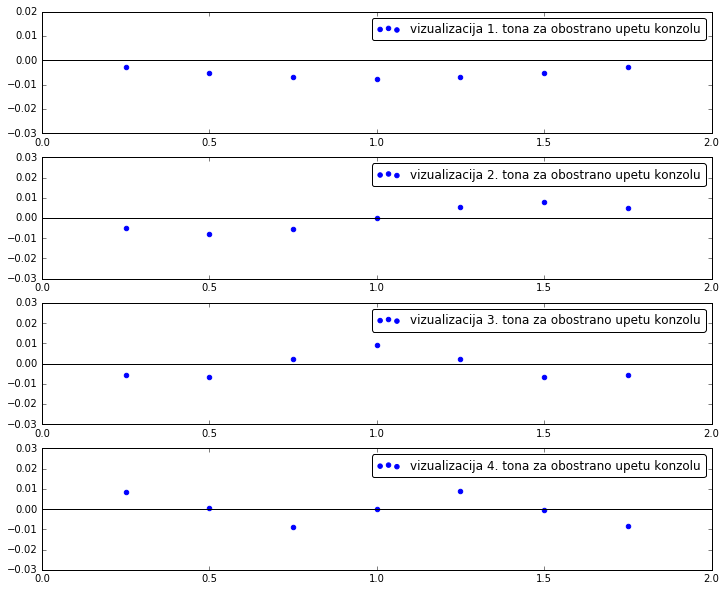

In [43]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
nosac = np.linspace(0.25,1.75,7)
for ton in range(4):
    axes[ton].scatter(nosac, evektori(2*n_primjer, "u", "u")[1::2,ton], color="blue",
                 label="vizualizacija %s. tona za obostrano upetu konzolu" %(ton+1))
    axes[ton].axhline(0, color = "black")
    axes[ton].set_xlim(0, 2)
    axes[ton].legend(fancybox=True)
    plt.draw()
    fig.savefig('tonovi.png', dpi=100)

### Ispis frekvencija prva četiri tona za različite rubne uvjete 
Na ordinati je broj konačnih elemenata pa će se moći vidjeti kako rezultati konvergiraju analitičkom s povećanjem broja konačnih elemenata. Prikazat će se rezultati za n skup prirodnih brojeva n = {3,20}. Kod četvrtog tona se vidi da sa samo četiri konačna elementa nije moguće dobiti smislene rezultate.

Zato se preferira da se proračun vrši s 8 konačnih elemenata!


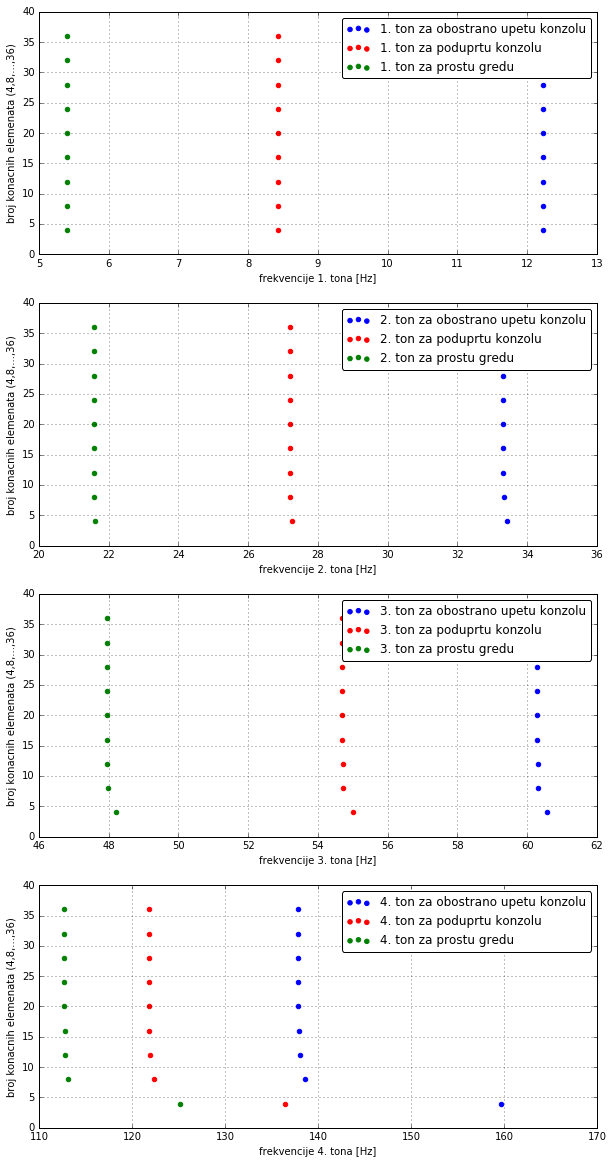

In [20]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
for ton in range(4):
    for niz in range(1,10):
        axes[ton].scatter(f(niz*n_primjer, "u", "u")[ton], niz*n_primjer, color="blue",
                 label="%s. ton za obostrano upetu konzolu" %(ton+1) if niz == 1 else "")
        axes[ton].scatter(f(niz*n_primjer, "u", "z")[ton], niz*n_primjer, color="red",
                 label="%s. ton za poduprtu konzolu" %(ton+1) if niz == 1 else "")
        axes[ton].scatter(f(niz*n_primjer, "z", "z")[ton], niz*n_primjer, color="green",
                 label="%s. ton za prostu gredu" %(ton+1) if niz == 1 else "")
        axes[ton].set_xlabel("frekvencije %s. tona [Hz]" %(ton+1))
        axes[ton].set_ylabel("broj konacnih elemenata (4,8,...,36)")
        axes[ton].grid()
    axes[ton].legend(fancybox=True)
        
#axes.axvline(15.97, color="blue", 
#             label = "analiticko rjesenje prvog tona za obostrano upetu konzolu")
#axes.axvline(11.01, color="red", 
#             label = "analiticko rjesenje prvog tona za poduprtu konzolu")
#axes.axvline(7.05, color="green", 
#             label = "analiticko rjesenje prvog tona za za prostu gredu")

Dno zadnjeg grafa pokazuje da s četiri konačna elemenata nije moguće dobiti četvrti ton. Taj dio grafa ispisuje točke koje su povezane s kutevima zaokreta.

S obzirom da se za mali broj konačnih elemenata dobivaju veće frekvencije od stvarnih, moguće je zadržati korak u proračunu $\Delta t = T_4 / 20$ jer će na taj način biti više od dvadeset koraka u najkraćem periodu.

## Rayleigh-ova matrica prigušenja

Ovaj korak u literaturi je nazvan step 4. Pretpostavlja se da je relativno prigušenje jednako i u prvom i u drugom tonu.

$$\alpha_0 = \alpha = \frac{2 \xi  \omega_1 \omega_2}{\omega_1 + \omega_2}$$

$$\alpha_1 = \beta = \frac{2 \xi}{\omega_1 + \omega_2}$$

$$C = \alpha_0 M + \alpha_1 K$$

gdje su:

- C - Rayleigh-ova matrica prigušenja

- $\xi$ - relativno prigušenje

- $\omega_1 , \omega_2$ - kružne frekvencije

- $\alpha_0 , \alpha_1$ - Rayleigh koeficijenti matrice prigušenja

In [21]:
def alfa(n, r_u_l, r_u_d):
    alfa_1 = 2*ksi/np.sum(w(n, r_u_l, r_u_d)[0:2])
    alfa_0 = alfa_1*np.prod(w(n, r_u_l, r_u_d)[0:2])
    return alfa_0, alfa_1

def C(n, r_u_l, r_u_d):
    """Racunanje Rayleigh-ove matrice prigusenja"""
    return (alfa(n, r_u_l, r_u_d)[0] * M_ss(n, r_u_l, r_u_d)
            + alfa(n, r_u_l, r_u_d)[1] * K_ss(n, r_u_l, r_u_d))

("Rayleigh koeficijenti su: ", alfa(n_primjer, r_u_l_primjer, r_u_d_primjer), 
"Matrica prigusenja je: ", C(n_primjer, r_u_l_primjer, r_u_d_primjer))

('Rayleigh koeficijenti su: ',
 (4.0467391834897706, 0.00044592869526873522),
 'Matrica prigusenja je: ',
 array([[ 8.67,  0.  , -3.84,  0.97,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.66, -0.97,  0.16,  0.  ,  0.  ,  0.  ],
        [-3.84, -0.97,  8.67,  0.  , -3.84,  0.97,  0.  ],
        [ 0.97,  0.16,  0.  ,  0.66, -0.97,  0.16,  0.  ],
        [ 0.  ,  0.  , -3.84, -0.97,  8.67,  0.  ,  0.97],
        [ 0.  ,  0.  ,  0.97,  0.16,  0.  ,  0.66,  0.16],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.97,  0.16,  0.33]]))

## Matrica utjecajnih koeficijenata $\Gamma$

Ovaj korak u literaturi je nazvan step 5. Za single support excitation i npr. obostrano upetu konzolu, matrica utjecajnih koeficijenata je dimenzija 4x4 , na dijagonali su (1,0,1,0) - nule predstavljaju potresnu ekscitaciju kuteva zaokreta. Single support excitation je ustvari primjer multi support excitation-a gdje su kašnjenja potresnog signala jednaka nuli. Preuzet će se opći postupak kao za multi support excitation, isti je dan u nastavku:

$$\Gamma = -K_{ss}^{-1} K_{sg}$$

In [22]:
def Gama(n, r_u_l, r_u_d):
    return -np.linalg.inv(K_ss(n, r_u_l, r_u_d)).dot(K_sg(n, r_u_l, r_u_d))

Gama(n_primjer, r_u_l_primjer, r_u_d_primjer) #.shape[1]

array([[ 0.91,  0.33,  0.09],
       [-0.33,  0.34,  0.33],
       [ 0.69,  0.37,  0.31],
       [-0.56, -0.12,  0.56],
       [ 0.37,  0.23,  0.63],
       [-0.7 , -0.41,  0.7 ],
       [-0.75, -0.5 ,  0.75]])

## Potresni zapis

Ovaj korak u literaturi je nazvan step 6. Koristi se stvarni potresni zapis potresa Elcentro preuzet sa stranice http://www.vibrationdata.com/elcentro.dat.

Za eventualno korištenje drugog potresnog zapisa samo je potrebno promjeniti naziv korištene datoteke u prvoj liniji
xg = np.fromfile('potres.dat', sep=' '). Za harmoničnu pobudu je potrebno upisati "A sinus T" gdje su A amplituda i T period. Za konstantu pobudu (vlastita težina) je potrebno upisati "const".

- "const" - vlastita težina

    $ F(t) = 9.81 $
    

- "A sinus T" - harmonična pobuda gdje je A amplituda, a T period

    $ F(t) = A \sin (\omega t) = A \sin (\frac {2 \pi * t} {T}) $
    

- "El Centro"

- itd.

Za harmoničnu pobudu i za rezultate eksperimenta je potrebna numerička pretvorba zapisa pomaka u akceleracije. Koristiti će se metoda konačnih razlika.

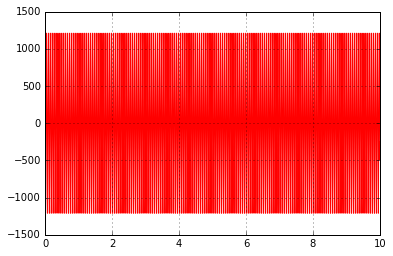

In [23]:
def MKR(f,df):
    prva = np.gradient(f, df)
    druga = np.gradient(prva, df)
    return prva, druga

xx = np.linspace(0,10,100000)
dxx = xx[1] - xx[0]
yy = 0.1 * np.sin(110 * xx)
#yy = xx**2 + 1
plt.plot(xx, yy,  xx, MKR(yy,dxx)[0],  xx, MKR(yy,dxx)[1])
plt.grid()

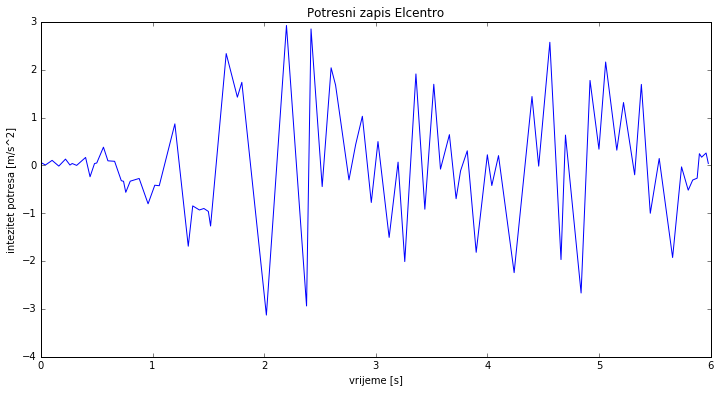

In [44]:
def xg_vrijeme_osn(potres, delay_t):
    """Za bolje funkcije je """
    if "sinus" in potres or potres == "const":
        xg_vrijeme_zapis = np.linspace(0,t+delay_t,(t+delay_t)/delta_t)
    elif potres == "eksperiment":
        xg = np.fromfile("eksperiment.dat", sep=' ')
        xg_vrijeme_zapis = xg[0::3] * 0.00625
    else:
        xg = np.fromfile(potres + ".dat", sep=' ')
        xg_vrijeme_zapis = xg[::2] # parne vrijednosti elcentro.dat ~~~ npr. 0,2,4,...
        korak = xg_vrijeme_zapis[1] - xg_vrijeme_zapis[0]
        xg_vrijeme_zapis = xg_vrijeme_zapis[:int((t+delay_t)/korak)]
    return xg_vrijeme_zapis

def xg_intezitet_osn(potres, delay_t):
    """Ova funkcija izvlaci potresni zapis iz pripremljenih datoteka kao npr.
    El Centro. Za harmonicnu pobudu je potrebno napisati A sin T sa razmakom.
    Trajanje bilo kojeg potresa ce biti jednako varijabli t definiranoj u
    poglavlju Ulazni podaci."""
    if "sinus" in potres:
        A = float(potres.split(" sinus ")[0])
        T = float(potres.split(" sinus ")[1])
        intezitet = A * np.sin(2*np.pi * xg_vrijeme_osn(potres, delay_t)  / T)
    elif potres == "const":
        intezitet = xg_vrijeme_osn(potres, delay_t)*0 + 9.81
    elif potres == "eksperiment":
        xg = np.fromfile("eksperiment.dat", sep=' ')
        pomak = (xg[2::3] - xg[2]) / 100 # [cm]
        #intezitet = np.gradient(np.gradient(pomak, 0.00625), 0.00625) # MKR - central difference
        intezitet = pomak
    else:
        xg = np.fromfile(potres + ".dat", sep=' ')
        xg_vrijeme_zapis = xg[::2] # parne vrijednosti elcentro.dat ~~~ npr. 0,2,4,...
        korak = xg_vrijeme_zapis[1] - xg_vrijeme_zapis[0]
        intezitet = xg[1::2][:int((t+delay_t)/korak)] * 9.81 # neparne vrijednosti elcentro.dat ~~~ npr. 1,3,...
    return intezitet

fig, axes = plt.subplots(figsize = (12,6))
axes.plot(xg_vrijeme_osn("Elcentro", delay_t_primjer),
          xg_intezitet_osn("Elcentro", delay_t_primjer))
axes.set_xlabel("vrijeme [s]")
axes.set_ylabel("intezitet potresa [m/s^2]")
axes.set_title("Potresni zapis Elcentro")

### Definiranje kašnjenja potresnog zapisa

Ovisno o r, broju stupaca matrice utjecajnih koeficijenata, se definiraju potresni zapisi za onemogućene/definirane stupnjeve slobode (eng. support degrees of freedom). Način uvođenja varijable r je računski zahtjevan, ali garantira točnost. Varijabla r je broj komponenti ulaznih potresnih signala.

Ispod koda je plot potresnih zapisa. Iz njega se vidi da je definirano da za kuteve zaokreta nema potresne pobude. Proračun koristi prvih t + delay_t sekundi potresnih zapisa te odbacuje ostatak ukoliko isti postoji.


Nije moguce kasnjenje vece od trajanja potresa!
Nije moguce kasnjenje vece od trajanja potresa!
Nije moguce kasnjenje vece od trajanja potresa!


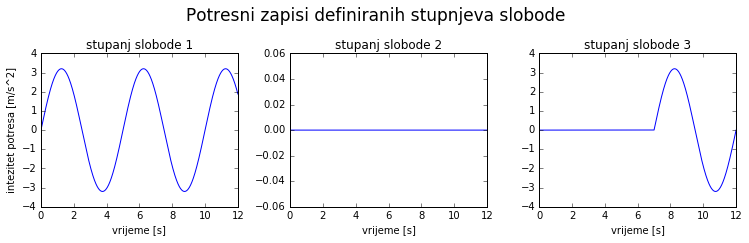

In [25]:
def xg_vrijeme(delay_t):
    return np.linspace(0,t+delay_t,(t+delay_t)/delta_t)

def xg_intezitet(delay_t, r_u_l, r_u_d, potres):
    """
    Potresni zapis se generalizira odnosno produžuje i uvodi kašnjenje
    za desni oslonac. Varijabla r predstavlja broj stupaca matrice utjecajnih
    koeficijenata odnosno broj definiranih stupnjeva slobode.
    Radi potrebe za smanjenjem vremenskog koraka (20 koraka u najkraćem periodu)
    se koristi funkcija np.interp(). Ona linearno intepolira potresni zapis
    te na taj način uvode vrijednosti varijable zapis za manji vremenski korak.
    """
    if delay_t > t:
        print("Nije moguce kasnjenje vece od trajanja potresa!")
        
    r = Gama(n_primjer, r_u_l, r_u_d).shape[1]
    if "sinus" not in potres or potres != "const":
        zapis = np.interp(np.linspace(0,t,int((t+delay_t)/delta_t)), 
                          xg_vrijeme_osn(potres, delay_t),
                          xg_intezitet_osn(potres, delay_t))
    if "sinus" in potres or potres == "const":
        zapis = xg_intezitet_osn(potres, delay_t)
    xg_intezitet = np.zeros((r, int((t+delay_t)/delta_t))) # iniciranje nul matrice
    xg_intezitet[0,:int((t+delay_t)/delta_t)]= zapis
    if r_u_l == "z":
        xg_intezitet[1,int(delay_t/delta_t):]= zapis[:int(t/delta_t)]
    elif r_u_d == "s":
        pass
    elif r_u_l == "u":
        xg_intezitet[2,int(delay_t/delta_t):]= zapis[:int(t/delta_t)]
    return xg_intezitet

def plot_zapisi(delay_t, r_u_l, r_u_d, potres):
    """Plot potresnih zapisa na definirane stupnjeve slobode. Ulazni podaci osim
    kasnjenja su i rubni uvjeti."""
    r = Gama(n_primjer, r_u_l, r_u_d).shape[1]
    fig, axes = plt.subplots(1, r, figsize=(3.5*r, 3))
    fig.suptitle("Potresni zapisi definiranih stupnjeva slobode", y=1.10, fontsize=17)
    for i in range(r):
        axes[i].plot(xg_vrijeme(delay_t), xg_intezitet(delay_t, r_u_l, r_u_d, potres)[i,:])
        axes[i].set_xlabel("vrijeme [s]")
        axes[i].set_ylabel("intezitet potresa [m/s^2]" if i == 0 else "")
        axes[i].set_title("stupanj slobode %s"%(i+1))
    plt.tight_layout()
    
plot_zapisi(7, r_u_l_primjer, r_u_d_primjer, "3.2 sinus 5.0")

Nije moguce kasnjenje vece od trajanja potresa!
Nije moguce kasnjenje vece od trajanja potresa!
Nije moguce kasnjenje vece od trajanja potresa!


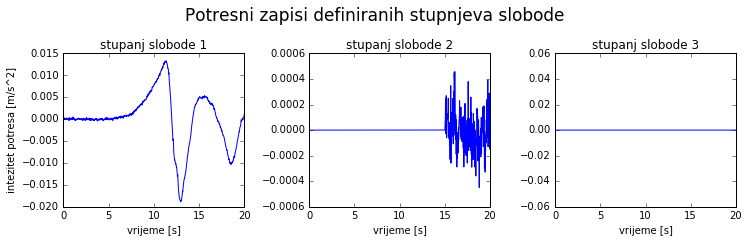

In [46]:
plot_zapisi(15, "z", "u", "eksperiment")

In [27]:
xg_intezitet_osn("eksperiment", 5)

array([  0.00e+00,   8.32e-01,  -7.68e-01, ...,   7.04e-01,  -1.39e-16,
         1.02e+00])

## Prijelazna matrica

Ovaj korak u literaturi je nazvan step 7. Za računanje dinamičke prijelazne patrice $A_d$ se koristi Pade-ova aproksimacija za matrični eksponent.

Napravljena je preinaka proračuna prikazanog u literaturi, odbacivanje "shear building" pretpostavke te korištenje kuteva zaokreta za stupnjeve slobode. Radi korištenja konzistentne matrice masa je ovdje moguće dobiti inverz matrice masa.

$$A_d = e^{A \Delta t}$$

$$A = \begin{bmatrix}
    0 & I\\
    -M_{ss}^{-1} K_{ss} & -M_{ss}^{-1} C_{ss}\\
\end{bmatrix}$$

In [28]:
def A_A(n, r_u_l, r_u_d):
    """Radi formiranja prijelaznih matrice A i A_d pomoću nested arraya je potrebno
    provjeriti dimenzije matrica krutosti (odnosno prigušenja i masa) - varijabla dim."""
    dim = K_ss(n, r_u_l, r_u_d).shape[0]
    A_10 = np.dot(-np.linalg.inv(M_ss(n, r_u_l, r_u_d)) , K_ss(n, r_u_l, r_u_d))
    A_11 = np.dot(-np.linalg.inv(M_ss(n, r_u_l, r_u_d)) , C(n, r_u_l, r_u_d))
    A = np.vstack((np.hstack((np.zeros((dim,dim)),np.identity(dim))),
                   np.hstack((A_10,A_11))))
    A_d = la.expm(A*delta_t)
    return A, A_d

def A(n, r_u_l, r_u_d):
    return A_A(n, r_u_l, r_u_d)[0]

def A_d(n, r_u_l, r_u_d):
    return A_A(n, r_u_l, r_u_d)[1]

#A(n_primjer, r_u_l_primjer, r_u_d_primjer)
#A_d(n_primjer, r_u_l_primjer, r_u_d_primjer)

## Vektor stanja

Ovi koraci u literaturi su nazvani step 8 i step 9. Cilj je pronači vektor stanja z. Koristi se multi support računski pristup i za single support excitation. Prvo se izračuna "ulaz" $E_d$ i $E$ prostora stanja (state space).
$$ z_{k+1} = A_d z_k + E_d $$

$$ E_d = A^{-1} (A_d - I) E $$

$$ E = \begin{bmatrix}
    0_{nxr} \\
    - \Gamma {\ddot{x}_g}_{nxr} \\
\end{bmatrix} $$

In [29]:
def E_E(n, r_u_l, r_u_d, delay_t, potres):
    """Radi formiranja vektora stanja E i E_d pomoću nested arraya je potrebno provjeriti
    dimenzije matrica krutosti (odnosno prigušenja i masa) - varijabla dim."""
    dim = K_ss(n, r_u_l, r_u_d).shape[0]
    E_0 = np.vstack(((np.zeros((dim, int((t+delay_t)/delta_t)))),
                   (-Gama(n, r_u_l, r_u_d).dot(xg_intezitet(delay_t, r_u_l, r_u_d, potres))))) 
    E_1 = (np.linalg.inv(A(n, r_u_l, r_u_d)).dot
           (A_d(n, r_u_l, r_u_d) - np.identity(2*dim)).dot
           (E_0))
    return E_0, E_1 # = E_s, E_d

def E_s(n, r_u_l, r_u_d, delay_t, potres):
    """Naziv sugerira E_staticno - u literaturi se koristi oznaka E koja je već zauzeta s
    modulom elastičnosti"""
    return E_E(n, r_u_l, r_u_d, delay_t, potres)[0]

def E_d(n, r_u_l, r_u_d, delay_t, potres):
    return E_E(n, r_u_l, r_u_d, delay_t, potres)[1]

#E_s(n_primjer, r_u_l_primjer, r_u_d_primjer, delay_t_primjer, "elcentro")
#E_d(n_primjer, r_u_l_primjer, r_u_d_primjer, delay_t_primjer, "elcentro")

## Dinamička analiza u vremenu (eng. time history) metodom prostora stanja (eng. state space method)

Računaju se pomaci, brzine i ubrzanja za svaki vremenski korak delta_t. Ispod je dana iterativna procedura metode prostora stanja. Koriste se praktički sve dosad definirane funkcije. 

Definiranjem funkcije prostor_stanja će se proračun moći pozvat jednom naredbom za: 

- odabrani broj konačnih elemenata, 
- odabrane rubne uvjete, 
- odabrano kašnjenje potresnog signala
- odabrani potres(uz biranje parametara za harmoničnu pobudu). 

$$ z_{k+1} = A_d z_k + E_d $$

$$ \dot{z}_{k+1} = A z_k + E $$

$$ z = \begin{bmatrix}
    x \\
    \dot{x} \\
\end{bmatrix} $$

$$ \dot{z} = \begin{bmatrix}
    \dot{x} \\
    \ddot{x} \\
\end{bmatrix} $$

In [30]:
def prostor_stanja(n, r_u_l, r_u_d, delay_t, potres):
    """
    ... Reshape funkcija pretvara vektor s m clanova u matricu m x 1 
    (slicna logika kao u Matlabu). Varijabla xg_sveukupno zbraja inercijalnu
    silu i potresnu silu....
    """
    
    vrijeme = delta_t
    i = 1
    dim = K_ss(n, r_u_l, r_u_d).shape[0]
    
    # iniciranje nul matrica :
    z = np.zeros([2*dim,int((t+delay_t)/delta_t)])
    z_dot = np.zeros([2*dim,int((t+delay_t)/delta_t)]) 
    xg_sveukupno = np.zeros([dim,int((t+delay_t)/delta_t)])
    
    # iniciranje "rubnog uvjeta" ubrzanja u trenutku t=0 :
    # z_dot[dim:,0] = xg_intezitet_osn[0] # ~iskljuceno~ 
     
    # pomocne varijable - radi preglednosti u petlji :
    A_pom = A(n, r_u_l, r_u_d)
    A_d_pom = A_d(n, r_u_l, r_u_d)
    E_pom = E_s(n, r_u_l, r_u_d, delay_t, potres)
    E_d_pom = E_d(n, r_u_l, r_u_d, delay_t, potres)
    xg_intezitet_pom = xg_intezitet(delay_t, r_u_l, r_u_d, potres)
    
    # petlja :
    while vrijeme <= xg_vrijeme(delay_t)[-2]:
        z[:,i:(i+1)] =  A_d_pom.dot(z[:,(i-1):i]) + E_d_pom[:,i-1].reshape(2*dim,1)
        z_dot[:,i:(i+1)] = A_pom.dot(z[:,i:(i+1)]) + E_pom[:,i].reshape(2*dim,1)
        xg_sveukupno[:,i] = z_dot[dim:,i] + Gama(n, r_u_l, r_u_d).dot(xg_intezitet_pom[:,i])
        vrijeme += delta_t
        i += 1
    return z, z_dot, xg_sveukupno

# rjesenje (pomaci):
# prostor_stanja(n_primjer, r_u_l_primjer, r_u_d_primjer, delay_t_primjer, "1 sinus 2")[0][:5,:]

### Prikaz rješenja

Donja funkcija ispisuje rješenja. Trenutno su parametri odabrani kao za "primjer", a potres je ustvari vlastita težina
s odmakom u fazi - kašnjenje od 1 sekunde na desnom ležaju.

Znači grafovi prikazaju dinamičku relaksaciju.

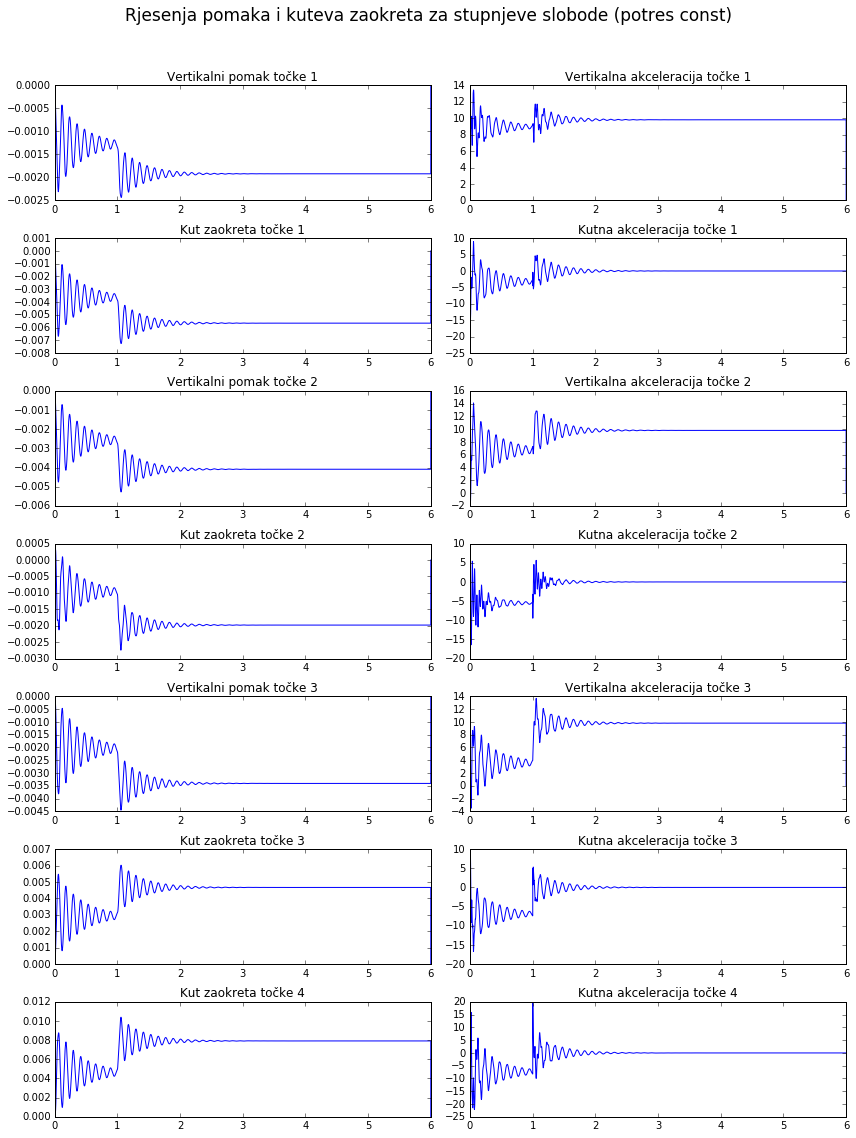

In [49]:
def plot_rjesenja(n, r_u_l, r_u_d, delay_t, potres):
    """Plot... paziti da n ne bude prevelik broj jer ce onda biti previse plotova"""
    dim = K_ss(n, r_u_l, r_u_d).shape[0]
    r = Gama(n_primjer, r_u_l, r_u_d).shape[1]
    pomak = prostor_stanja(n, r_u_l, r_u_d, delay_t, potres)[0][:dim,:]
    akceleracija_uk = prostor_stanja(n, r_u_l, r_u_d, delay_t, potres)[2]
    fig, axes = plt.subplots(dim, 2, figsize = (12,15))
    fig.suptitle("Rjesenja pomaka i kuteva zaokreta za stupnjeve slobode (potres %s)"
                 %(potres), y=1.05, fontsize=17)
    for i in range(dim):
        axes[i,0].plot(xg_vrijeme(delay_t), pomak[i,:])
        axes[i,1].plot(xg_vrijeme(delay_t), akceleracija_uk[i,:])
        #axes[i].set_xlabel("vrijeme [s]")
        if i == 0 and r_u_l == "z":
            axes[0,0].set_title("Kut zaokreta točke %s"%(i//2+1))
            axes[0,1].set_title("Kutna akceleracija točke %s"%(i//2+1))
        else:
            axes[i,0].set_title("Kut zaokreta točke %s"%(i//2+1) if i%2 == 1 
                                else "Vertikalni pomak točke %s"%(i//2+1))
            axes[i,1].set_title("Kutna akceleracija točke %s"%(i//2+1) if i%2 == 1 
                                else "Vertikalna akceleracija točke %s"%(i//2+1))
        if i == (dim-1) and r_u_d == "z":
            axes[i,0].set_title("Kut zaokreta točke %s"%(i//2+1))
            axes[i,1].set_title("Kutna akceleracija točke %s"%(i//2+1))
    plt.tight_layout()


def proba():
    ksi = 0.99
    plot_rjesenja(n_primjer, r_u_l_primjer, r_u_d_primjer, delay_t_primjer, "const") 
    
proba()
# provjeriti dali su dobri naslovi grafova - nisu trenutno

## Validacija koda

Plan je provesti provjere:
    
- usporedba rješenja dinamičke relaksacije sa analitičkim izrazom za progib

- traženje maksimalnog pomaka u ovisnosti o frekvenciji hamornične pobude

- usporedba sa kodom profesora Bićanića gdje se koristi direktna integracija pomoću konačnih razlika

- usporedba sa rješenjima iz komercijalnog sofware-a SAAP

- te u sljedećem poglavlju usporedba s eksperimentima.

### Dinamička relaksacija

Analitički izraz za progib je poznat iz statike. Ne očekuju se najbolja podudaranja jer će se dodatne mase svesti na kontinuirano opterećenje.

$$ w_{max} = w(\frac {L} {2}) = \frac{5}{384} \frac {q l^4} {E I}$$

In [32]:
q = (rho*b*h + 3*m_uteg/l) * 9.81
w_max_an = 5/384 * q*l**4/(E*I)
print("Maksimalni progib od vlastite tezine dobiven analiticki iznosi ", w_max_an, "[m].")

Maksimalni progib od vlastite tezine dobiven analiticki iznosi  0.009697812357760583 [m].


In [33]:
w_max_num = -prostor_stanja(4, "z", "z", 0, "const")[0][3,-2] 
# indeks 3 u gornjoj liniji je za translatorni stupanj slobode na polovici grede
print("Maksimalni progib od vlastite tezine dobiven numericki iznosi", 
      w_max_num, "[m].")

Maksimalni progib od vlastite tezine dobiven numericki iznosi 0.0100287994086 [m].


In [34]:
# izracun odstupanja

odstupanje = (w_max_num-w_max_an)/w_max_num
print("Greška je zadovoljavajućih %s posto." %(100*odstupanje.round(4)))

Greška je zadovoljavajućih 3.3 posto.


### Spektralna analiza

Variranjem harmonične pobude će se tražiti maksimalni pomaci za rubne uvjete od proste grede. Želja je prepoznati rezonanciju na grafovima te vidjeti ako se domene rezonancije podudaraju sa dobivenim frekvencijama.

In [35]:
frekvencije = f(n_primjer*2, "z", "z")[:4] # prve 4 frekvencije
period = frekvencije ** (-1)
np.set_printoptions(4)
simetricni = frekvencije[::2]
asimetricni = frekvencije[1::2]
period

array([ 0.1852,  0.0464,  0.0208,  0.0088])

In [36]:
import time
np.set_printoptions(2)

In [37]:
# dolje je dan ispis koji je od pomoci za shvacanje koda u nastavku
for i in [0,1]:
    for j, tonovi in enumerate([simetricni,asimetricni]):
        print(i, j, tonovi[i])

0 0 5.39831581085
0 1 21.5689460601
1 0 47.9756946632
1 1 113.175992221


Crtanje grafova je dugotrajno, a sa malim brojem diskretnih vrijednosti nije vidljivo ništa od značaja ako se crta preko cijelog raspona perioda. Napraviti će se po jedan graf za svaki značajni ton.

- Za asimetrične tonove će se promatrati maksimalni pomak na L/4 i uvest će se kašnjenje potresa od T/2. 

- Za simetrične tonove će se promatrati maksimalni pomak na L/2 i to bez kašnjenja potresa.

**Donji ispis traje 4 minute pa će se isključiti, po potrebi se može pokrenuti.**

Komentar: ...

### Usporedba sa kodom prof. Bićanića (direktna integracija pomoću konačnih razlika)

Procedura direktne integracije pomoću konačnih razlika (literatura Bathe):

A. Početni izračuni:

1. Definiranje matrice krutosti K, matrice masa M, i matrice prigušenja C.

2. Iniciranje $ ^0 U, ^0 \dot{U}, ^0 \ddot{U} .$

3. Odabir vremenskog koraka $\Delta t, \Delta t \leq \Delta t_{cr} = frac{T_n}{\pi} $, i računanje integracijskih konstanti: $$ \alpha_0 = \frac{1}{\Delta t^2}; \quad \alpha_1 = \frac{1}{ 2 \Delta t}; \quad \alpha_2 = 2 \alpha_0; \quad \alpha_3 = \frac{1}{\alpha_2} $$

4. Izračun $ ^{-\Delta t} U = {^0} U - \Delta t \cdot {^0} \dot{U} + \alpha_3 \cdot {^0} \ddot{U}  $

5. Formiranje efektivne matrice masa $ \hat M = \alpha_0 M + \alpha_1 C $

6. Napraviti trokutastu matricu $ \hat M : \hat M = L D L^T $

B. Za svaki vremenski korak:

1. Izračun efektivnog opterećenja u vremenu t: $$ ^t \hat R =  {^t} R - (K - \alpha_2 M) \cdot {^t} U - (\alpha_0 M - \alpha_1 C) \cdot {^{t - \Delta t}} U $$

2. Pronađu se pomaci u vremenu $ t + \Delta t $ : $$ L D L^T \cdot {^{t+\Delta t}} U = {^t} R $$

3. Ako se traži, izračunaju se akceleracije i brzine u vremenu $t$ : 

$$ ^t \ddot U = \alpha_0 ( ^{t-\Delta t} U - 2 \cdot {^t}U + {^{t+\Delta t}} U ) $$

$$ ^t \dot U = \alpha_1 (- {^{t-\Delta t}} U + {^{t+\Delta t}} U ) $$


Metoda konačnih razlika ima problem sa stabilnosti pa je potrebno pažljivo odabrati vremenski korak. S četiri konačna elementa imamo tri tona pa je period trećeg tona mjerodavan. Vremenski korak zadovoljava uvjet (150 puta manji od minimalnog).

$$ \Delta t = 0.00002 \leq \Delta t_{cr} = \frac{0.0208}{2 \pi} = 0.0033 $$


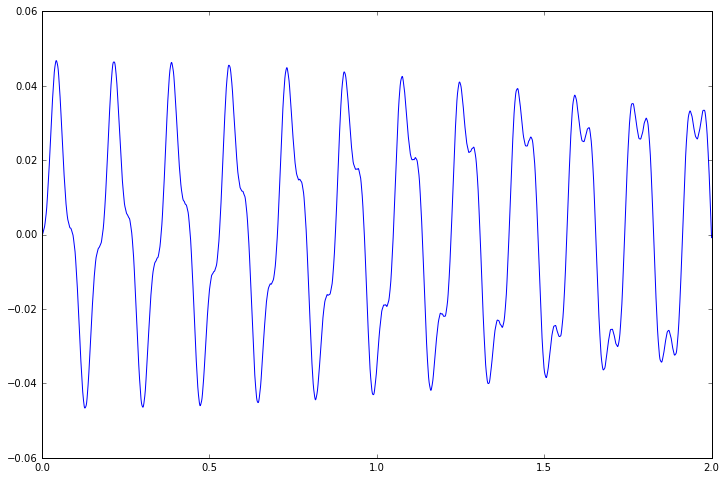

In [54]:
#kod je u funkciji da nebi utjecao na prije definirane varijable

def direktna_integracija_FDM():
    bb=0.04; hh=0.013; EL=12.5*10**9; LN=2./3.; IN=bb*hh*hh*hh/12;
    a=12*EL*IN/LN/LN/LN;b=6*EL*IN/LN/LN;c=-a;d=b;
    e=b;f=4*EL*IN/LN;g=-b;h=f/2;
    i=c;j=g;k=a;l=j;
    m=b;n=h;o=j;p=f;
    KK = np.array([[f, g, h, 0, 0, 0],[j, k+a, l+b, c, d, 0],[n, o+e, p+f, g, h, 0],
                   [0, i, j, a+k, b+l, d],[0, m, n, e+o, f+p, h],[0, 0, 0, m, n, p]]);
    MM = np.array([[0.001, 0, 0, 0, 0, 0],[0, 0.28, 0, 0, 0, 0],[0, 0, 0.001, 0, 0, 0],
                   [0, 0, 0, 0.28, 0, 0],[0, 0, 0, 0, 0.001, 0],[0, 0, 0, 0, 0, 0.001]]);
    dt=0.000002; om=110; shift=0.0; amp=0.10;
    IMM = dt * dt * np.linalg.inv(MM);
    nstep = 1000000;
    nn = np.zeros((1,6));
    xmin = nn.T; xcur = nn.T;
    tt, disp1, disp2 = [], [], []
    for istep in range(1,nstep):
        tt.append(istep*dt);
        v = amp*np.sin(om*tt[-1]); vsh = amp*np.sin(om*(tt[-1]+shift));
        ff = np.array([[-e*v, -i*v, -m*v, -c*vsh, -g*vsh, -o*vsh]]);
        rhs = ff.T - 1/dt/dt*MM.dot(xmin) - (KK-2/dt/dt*MM).dot(xcur);
        xnew = IMM.dot(rhs);
        disp1.append(xnew[1]);
        disp2.append(xnew[3]);
        #bound(istep)=v;
        xmin=xcur.copy(); xcur=xnew.copy();
    plt.figure(figsize=(12, 8))
    plt.plot(tt, disp1)
    
direktna_integracija_FDM()

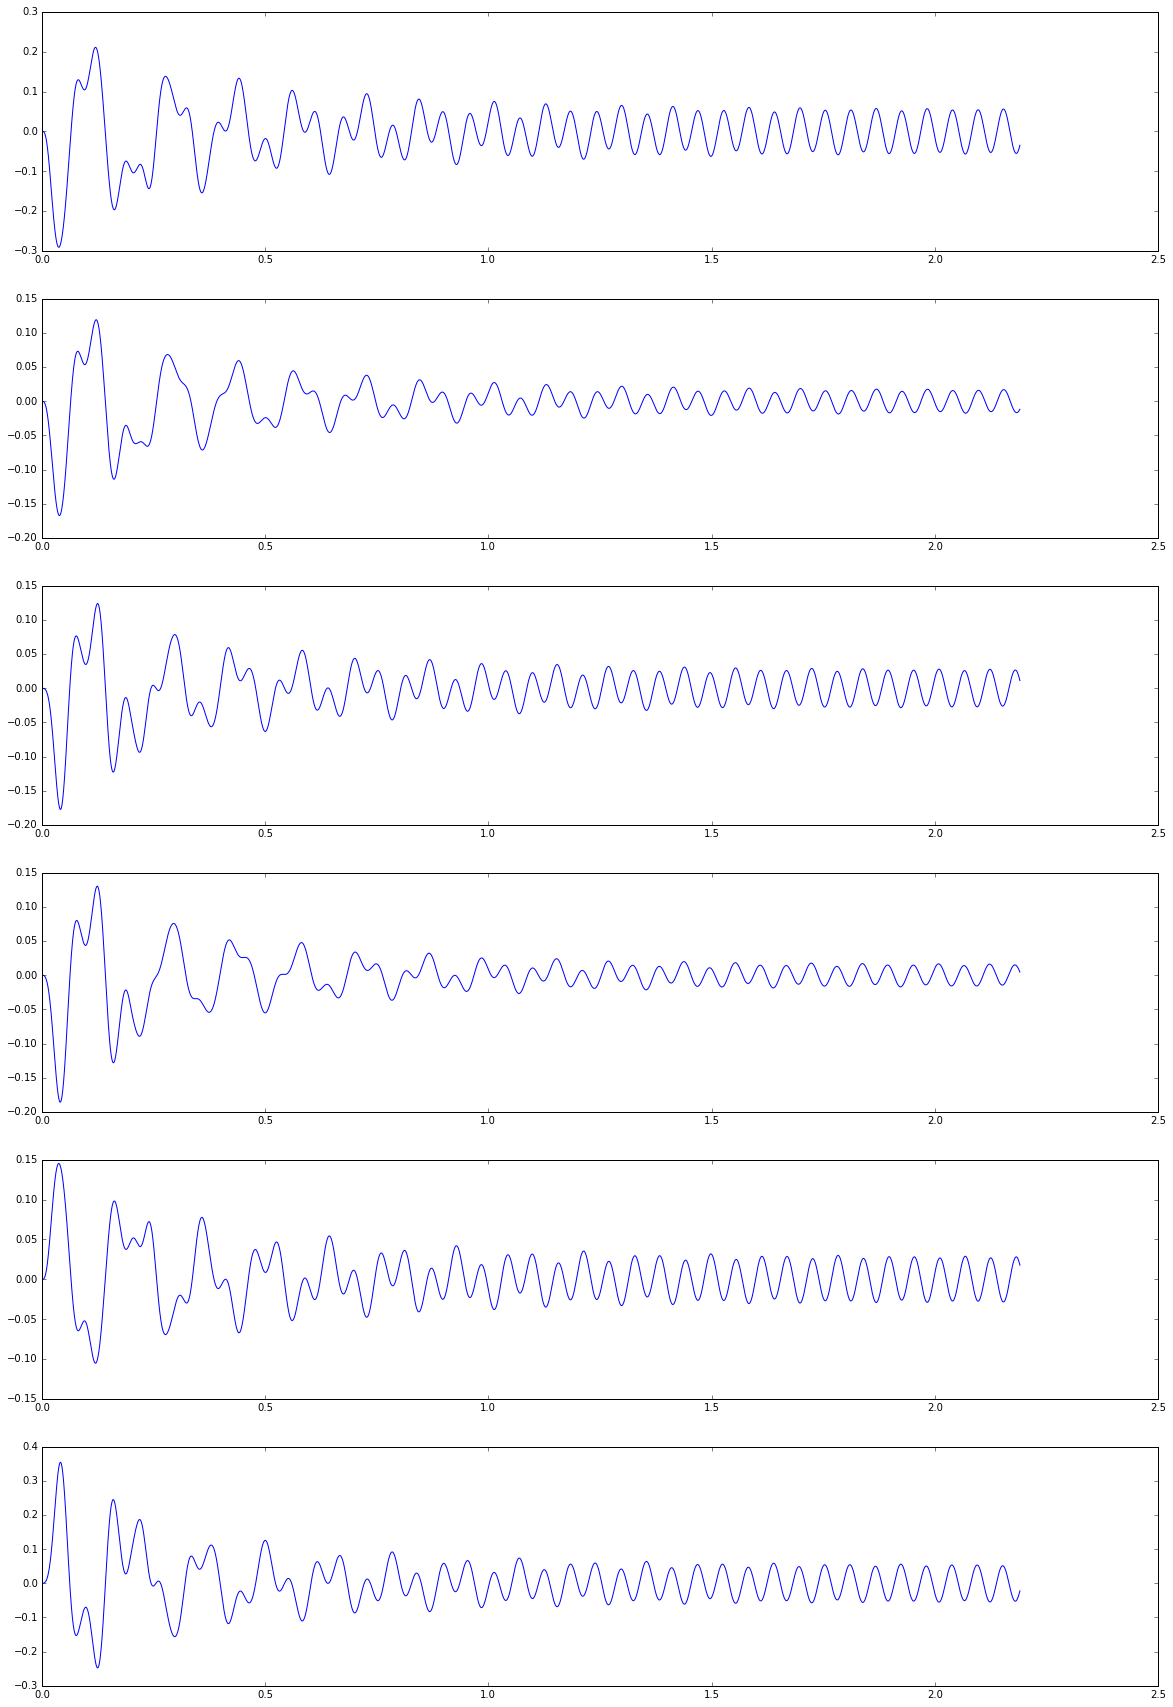

In [51]:
def usporedba_tot():
    t = 2.0
    ksi = 0.0
    pomak_uk = prostor_stanja(3, "z", "z", 0.2, "1210 sinus 0.057")[0][:6,:] + 0*xg_intezitet(0.2, "z", "z", "0.1 sinus 0.057")[0]
    fig, axes = plt.subplots(6, figsize = (20,30))
    for i in range(6):
        axes[i].plot(xg_vrijeme(0)[:7000], pomak_uk[i,:7000])
usporedba_tot()

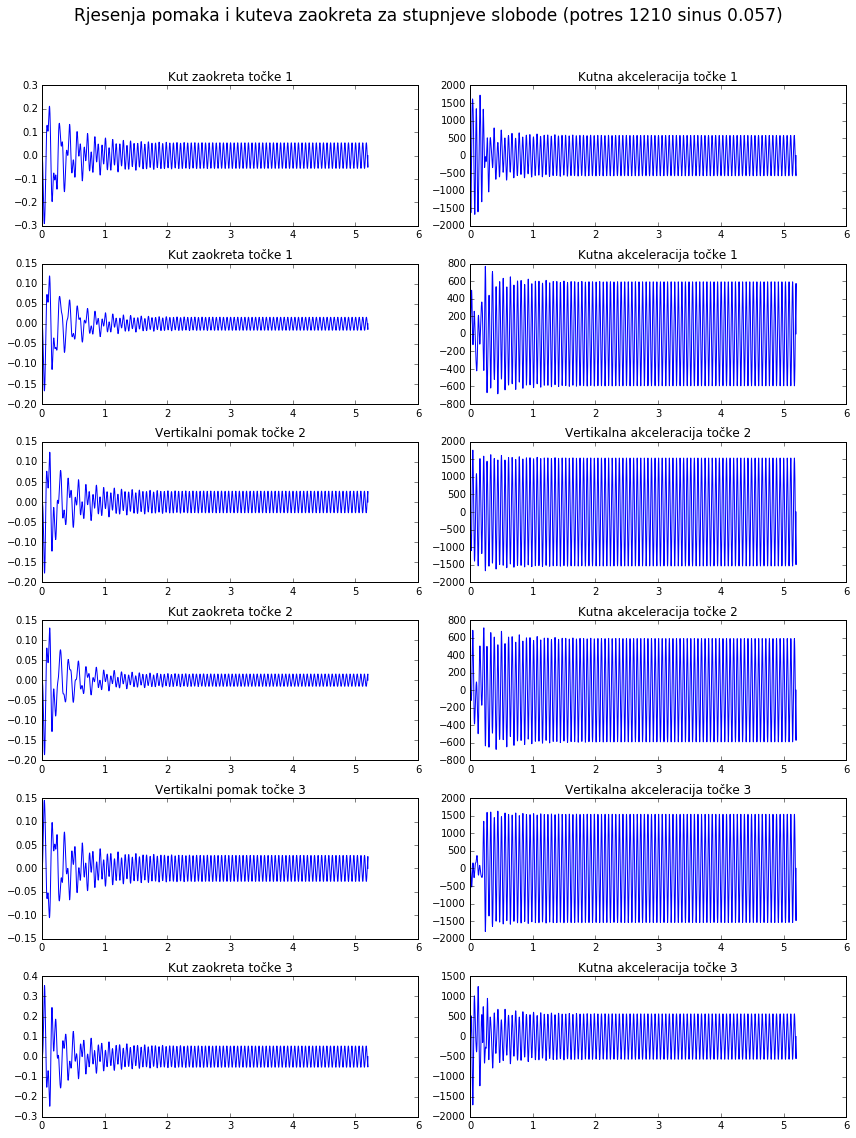

In [40]:
def usporedba_rel():
    t = 2.0
    ksi = 0.01
    plot_rjesenja(3, "z", "z", 0.2, "1210 sinus 0.057") # 0,057 = 2pi/110
usporedba_rel()

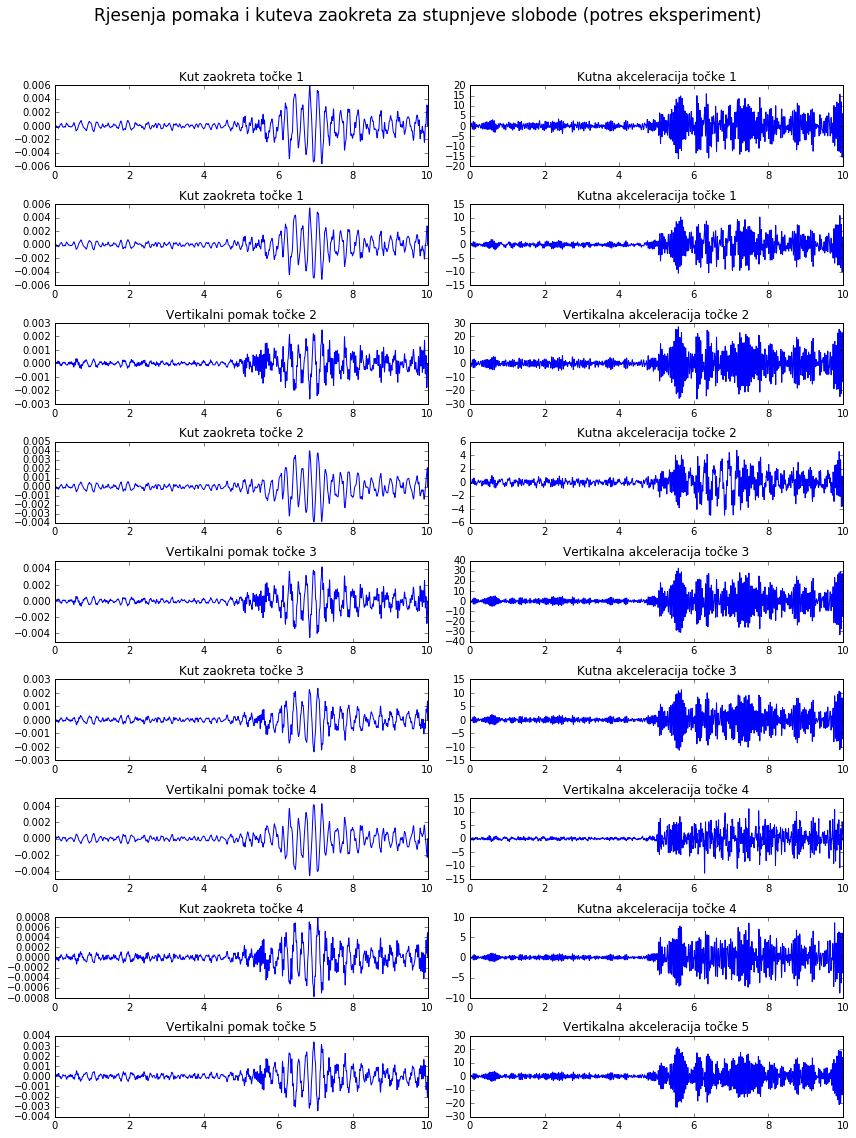

In [41]:
plot_rjesenja(5, "z", "u", 5, "eksperiment")